## arrcat

makes the HELCATS HI ARRIVAL catalog

Authors: C. Möstl, Austrian Space Weather Office, GeoSphere Austria; D. Barnes, J. A. Davies, R. A. Harrison, RAL Space, UK.

https://twitter.com/chrisoutofspace <br />
https://mastodon.social/@chrisoutofspace

This code is part of https://github.com/cmoestl/heliocats

**current version ARRCAT 2.0, released 2020 May 13, updated 2023 April 12**

Install a specific conda environment to run this code, see readme at https://github.com/cmoestl/heliocats

Convert this notebook to a script with "jupyter nbconvert --to script arrcat.ipynb", automatically done in first cell

This catalog is hosted at:

https://helioforecast.space/arrcat
https://doi.org/10.6084/m9.figshare.12271292


TO DO: further change to astrospice in cats.py



In [1]:
last_update='2023-April-12'

In [2]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
from datetime import timedelta
import seaborn as sns
import datetime
import astropy
import astropy.constants as const
from sunpy.time import parse_time
import time
import pickle
import sys
import os
import urllib
import json
import importlib
import pandas as pd
import copy
import openpyxl
import h5py
import heliopy

from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging

from heliocats import stats as hs
importlib.reload(hs) #reload again while debugging

#where the in situ data files are located is read 
#from config.py 
import config
importlib.reload(config)
from config import data_path
from config import data_path_ML

########### make directories first time if not there

resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

catdir='arrcat'
if os.path.isdir(catdir) == False: os.mkdir(catdir)

icplotsdir='arrcat/plots_arrcat/' 
if os.path.isdir(icplotsdir) == False: os.mkdir(icplotsdir) 

#Convert this notebook to a script with jupyter nbconvert --to script icmecat.ipynb
os.system('jupyter nbconvert --to script arrcat.ipynb')    

/nas/helio/heliofc/miniconda3/envs/helio2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[NbConvertApp] Converting notebook arrcat.ipynb to script
[NbConvertApp] Writing 22521 bytes to arrcat.py


0

## 1 Make HI SSEF30 arrival catalog ARRCAT

In [3]:
from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging 

#https://www.helcats-fp7.eu/
#LOAD HELCATS HIGeoCAT
url_higeocat='https://www.helcats-fp7.eu/catalogues/data/HCME_WP3_V06.vot'

try: urllib.request.urlretrieve(url_higeocat,'data/HCME_WP3_V06.vot')
except urllib.error.URLError as e:
    print('higeocat not loaded')

higeocat=hc.load_higeocat_vot('data/HCME_WP3_V06.vot')
higeocat_time=parse_time(higeocat['Date']).datetime    
higeocat_t0=parse_time(higeocat['SSE Launch']).datetime   #backprojected launch time

#define empty pandas dataframe for arrival catalog with column names

column_list=['id', 'sc','target_name','sse_launch_time','target_arrival_time','target_arrival_time_err',\
                                 'target_distance','target_heeq_lon','target_heeq_lat',\
                                 'target_delta','sse_heeq_lon','sse_heeq_lat',\
                                 'sse_speed','sse_speed_err','target_speed','target_speed_err',\
                                 'pa_fit','pa_n','pa_s','pa_center']
             
#pandas dataframe for current version with iteration in calculating arrival time
ac = pd.DataFrame([], columns = column_list)

#pandas dataframe for old method of arrival time prediction without iteration
ac_old = pd.DataFrame([], columns = column_list)

#Make arrival catalog from HIGEOCAT for each spacecraft

#active missions
[ac,ac_old]=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, ac_old, 'PSP',column_list)
[ac,ac_old]=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, ac_old, 'Solo',column_list)
[ac,ac_old]=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, ac_old, 'Bepi',column_list)   
[ac,ac_old]=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, ac_old, 'STA',column_list)
[ac,ac_old]=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, ac_old, 'Earth',column_list)

#finished missions
[ac,ac_old]=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, ac_old, 'STB',column_list)
[ac,ac_old]=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, ac_old, 'Ulysses',column_list)
[ac,ac_old]=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, ac_old, 'Mercury',column_list)
[ac,ac_old]=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, ac_old, 'Venus',column_list)
[ac,ac_old]=hc.make_arrival_catalog_insitu_ssef30(higeocat, ac, ac_old, 'Mars',column_list)


ac = ac.sort_values(by='target_arrival_time',ascending=False)
ac = ac.reset_index(drop=True)

ac_old = ac_old.sort_values(by='target_arrival_time',ascending=False)
ac_old = ac_old.reset_index(drop=True)

ac

SSEF30 events:  54
PSP  SSEF30 arrival catalog finished.



Files Downloaded: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.85file/s]


SSEF30 events:  39
Solo  SSEF30 arrival catalog finished.

SSEF30 events:  61
Bepi  SSEF30 arrival catalog finished.

SSEF30 events:  204
STA  SSEF30 arrival catalog finished.

SSEF30 events:  652
Earth  SSEF30 arrival catalog finished.

SSEF30 events:  139
STB  SSEF30 arrival catalog finished.

SSEF30 events:  22
Ulysses  SSEF30 arrival catalog finished.

SSEF30 events:  248
Mercury  SSEF30 arrival catalog finished.

SSEF30 events:  299
Venus  SSEF30 arrival catalog finished.

SSEF30 events:  300
Mars  SSEF30 arrival catalog finished.



,id,sc,target_name,sse_launch_time,target_arrival_time,target_arrival_time_err,target_distance,target_heeq_lon,target_heeq_lat,target_delta,sse_heeq_lon,sse_heeq_lat,sse_speed,sse_speed_err,target_speed,target_speed_err,pa_fit,pa_n,pa_s,pa_center
0,HCME_A__20230224_01,A,Mercury,2023-02-24 15:31,2023-02-25 06:28,3.4,0.454,128.24,-2.34,-11.8,140,1,1319,285,1262,273,260,225,280,252.5
1,HCME_A__20230221_01,A,STEREO-A,2023-02-21 03:01,2023-02-24 22:42,1.4,0.967,-12.88,-6.80,-25.9,13,-1,575,9,438,7,280,200,330,265.0
2,HCME_A__20230221_01,A,Earth_L1,2023-02-21 03:01,2023-02-24 05:44,1.2,0.980,-0.00,-7.12,-13.0,13,-1,575,9,545,9,280,200,330,265.0
3,HCME_A__20230220_01,A,Mercury,2023-02-20 05:01,2023-02-21 13:32,10.3,0.462,121.42,-2.75,-5.6,127,-4,596,173,590,171,255,200,305,252.5
4,HCME_A__20230219_02,A,Mercury,2023-02-19 15:26,2023-02-21 10:52,3.3,0.462,121.22,-2.76,27.2,94,-17,608,46,442,33,250,200,290,245.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,HCME_A__20070518_01,A,Venus,2007-05-17 20:34,2007-05-20 09:17,0.3,0.720,-57.25,-3.69,20.7,-78,-20,574,3,493,3,110,95,115,105.0
2014,HCME_A__20070518_01,A,Mercury,2007-05-17 20:34,2007-05-19 01:13,0.1,0.337,-99.24,0.56,-21.2,-78,-20,574,3,489,3,110,95,115,105.0
2015,HCME_A__20070516_01,A,Venus,2007-05-15 16:24,2007-05-18 23:10,0.2,0.720,-58.20,-3.74,-5.2,-53,16,383,1,380,1,70,30,120,75.0
2016,HCME_A__20070509_01,A,Mercury,2007-05-09 06:13,2007-05-10 07:53,2.8,0.308,-142.21,2.96,-0.2,-142,2,499,54,499,54,90,50,125,87.5


## 2 save ARRCAT


#### save header

In [4]:
#save header and parameters as text file and prepare for html website
header='ARRIVAL CATALOGUE 2.0 \n\n\
In this ARRival CATalog (ARRCAT), the arrivals of solar coronal mass ejections that were \n\
tracked in the STEREO heliospheric imagers in the HELCATS project are calculated.\n\
ARRCAT lists modeled arrivals of CMEs at various spacecraft and planets, \n\
based on the HIGeoCAT catalog of CMEs established at RAL Space, UK (D. Barnes, J. A. Davies, R. A. Harrison). \n\n\
This is version 2.0, released 2020-May-13, updated '+last_update+'. https://doi.org/10.6084/m9.figshare.12271292\n\n\
It is based on this HIGeoCAT version: '+url_higeocat+' using the SSEF30 model.\n\n\
The catalog is available as python pandas dataframe (pickle), \n\
python numpy arrays (pickle, as recarray and structured array), \n\
npy (numpy, no pickle), json, csv, xlsx, txt, hdf5, html at \n\
https://helioforecast.space/arrcat\n\n\
Number of events in ARRCAT: '+str(len(ac))+'\n\
Targets: Earth_L1, STEREO-A, STEREO-B, Solar Orbiter, Parker Solar Probe (PSP), Bepi Colombo, Ulysses, Venus, Mercury, Mars.\n\n\
Authors: Christian Moestl (1), D. Barnes (2), R. A. Harrison (2), J. A. Davies (2), Andreas J. Weiss (1,3), David Stansby (4);\n\
(1) Austrian Space Weather Office, GeoSphere Austria, Graz, Austria, (2) RAL Space, UK, (3) NASA Goddard Space Flight Center, USA (4) University College London, UK.\n\n\
Rules: If results are produced with this catalog for peer-reviewed scientific publications,\n\
please contact chris.moestl@outlook.com for co-authorships.\n\n\
Parameters \n\n\
    0: id: From HIGeoCAT, the unique identifier for the observed CME.\n\
    1: sc: From HIGeoCAT, the HI observing STEREO spacecraft, (A=Ahead or B=Behind)\n\
    2: target_name: Name of in situ target.\n\
    3: sse_launch_time: From HIGeoCAT, launch time of the CME at Sun center, unit: UTC.\n\
    4: target_arrival_time: CME arrival time at target location calculated with the SSEF30 model, corrected for SSE shape (Moestl and Davies, 2013). unit: UTC.\n\
    5: target_arrival_time_err: Error of CME arrival time at target location from SSEF30 model, solely based on error in parameter sse_speed_err. unit: hours.\n\
    6: target_distance: Target distance from Sun, at model CME arrival time. unit: AU.\n\
    7: target_heeq_lon: Target longitude in HEEQ, at model CME arrival time. unit: degree.\n\
    8: target_heeq_lat: Target latitude in HEEQ, at model CME arrival time. unit: degree.\n\
    9: target_delta: Difference in HEEQ longitude between central CME direction and target location at model CME arrival time, \n\
       positive values: spacecraft is west of CME apex. unit: degree.\n\
    10: sse_heeq_lon: From HIGeoCAT, the HEEQ longitude of the CME apex propagation direction, unit: degree.\n\
    11: sse_heeq_lat: From HIGeoCAT, the HEEQ latitude of the CME apex propagation direction, unit: degree.\n\
    12: sse_speed: From HIGeoCAT, speed of the CME apex, unit: km/s.\n\
    13: sse_speed_err: From HIGeoCAT, error in the speed of the CME apex, unit: km/s.\n\
    14: target_speed: CME arrival speed at target location, corrected for SSE shape (Moestl and Davies, 2013). unit: km/s.\n\
    15: target_speed_err: Error in CME arrival speed at target location, corrected for SSE shape (Moestl and Davies, 2013). unit: km/s.\n\
    16: pa_fit: From HIGeoCAT, PA along which time-elongation profile is extracted, unit: degree.\n\
    17: pa_n: From HIGeoCAT, northern position angle of CME, unit: degree.\n\
    18: pa_s: From HIGeoCAT, southernmost position angle of CME, unit: degree.\n\
    19: pa_center: average of pa_n and pa_s, unit: degree.\n\n\
Comments\n\n\
    - We have modified the calculation of CME arrival time here by a new iterative method compared to Moestl et al. (2014, 2017). \n\
      In the first iteration, the sse_launch_time is used to calculate the target HEEQ position. \n\
      In subsequent three iterations, we use the arrival time from the previous iteration (instead of sse_launch time) \n\
      to calculate the target HEEQ position. \n\
      In this way we avoid an error of a few degrees in the arrival target location (see also Moestl et al. 2017). \n\
    - The analytical formulas for calculating the speeds and arrival times of the CMEs modeled with SSEF30, \n\
      corrected for the SSEF30 circular shape, can be found in Moestl & Davies (2013). \n\n\n\
References \n\n\
Moestl & Davies (2013) https://doi.org/10.1007/s11207-012-9978-8 arxiv: https://arxiv.org/abs/1202.1299\n\
Moestl et al. (2014)   https://doi.org/10.1088/0004-637X/787/2/119 (open access) \n\
Moestl et al. (2017)   https://doi.org/10.1002/2017SW001614 (open access)\n'

print(header)

#make header file
file='arrcat/HELCATS_ARRCAT_v20_header.txt'
with open(file, "w") as text_file:
    text_file.write(header)
print()    
print('header saved as '+file)
print()    

#Convert to html regarding line breaks, paragraph beginning and spaces
header_spaces=header.replace(" ", "&nbsp;")
header_html= "<p>" +header_spaces.replace('\n', '<br>')+ "</p>" 
print('header converted to HTML')
print()    
print()    

print('-----------------------')
print('ARRCAT sorted by time gives:')
np.sort(ac.target_arrival_time)

ARRIVAL CATALOGUE 2.0 

In this ARRival CATalog (ARRCAT), the arrivals of solar coronal mass ejections that were 
tracked in the STEREO heliospheric imagers in the HELCATS project are calculated.
ARRCAT lists modeled arrivals of CMEs at various spacecraft and planets, 
based on the HIGeoCAT catalog of CMEs established at RAL Space, UK (D. Barnes, J. A. Davies, R. A. Harrison). 

This is version 2.0, released 2020-May-13, updated 2023-April-12. https://doi.org/10.6084/m9.figshare.12271292

It is based on this HIGeoCAT version: https://www.helcats-fp7.eu/catalogues/data/HCME_WP3_V06.vot using the SSEF30 model.

The catalog is available as python pandas dataframe (pickle), 
python numpy arrays (pickle, as recarray and structured array), 
npy (numpy, no pickle), json, csv, xlsx, txt, hdf5, html at 
https://helioforecast.space/arrcat

Number of events in ARRCAT: 2018
Targets: Earth_L1, STEREO-A, STEREO-B, Solar Orbiter, Parker Solar Probe (PSP), Bepi Colombo, Ulysses, Venus, Mercury, Mars.


array(['2007-04-22 23:34', '2007-05-10 07:53', '2007-05-18 23:10', ...,
       '2023-02-24 05:44', '2023-02-24 22:42', '2023-02-25 06:28'],
      dtype=object)

#### save into different formats

In [5]:
########## python formats

# save ARRCAT as pandas dataframe with times as datetime objects as pickle
file='arrcat/HELCATS_ARRCAT_v20_pandas.p'
pickle.dump([ac,header], open(file, 'wb'))
print('ARRCAT saved as '+file)

# save ARRCAT as numpy array with times as matplotlib datetime as pickle
ac_num=copy.deepcopy(ac) 
ac_num.sse_launch_time=parse_time(ac_num.sse_launch_time).plot_date
ac_num.target_arrival_time=parse_time(ac_num.target_arrival_time).plot_date
#convert to recarray
ac_num_rec=ac_num.to_records()
#create structured array 
dtype1=[('index','i8'),('id', '<U30'),('sc', '<U20'),('target_name', '<U20')] +[(i, '<f8') for i in ac.keys()[3:len(ac.keys())]]
ac_num_struct=np.array(ac_num_rec,dtype=dtype1)

file='arrcat/HELCATS_ARRCAT_v20_numpy.p'
pickle.dump([ac_num,ac_num_struct,header], open(file, 'wb'))
print('ARRCAT saved as '+file)




################ save to different formats

#copy pandas dataframe first to change time format consistent with HELCATS
ac_copy=copy.deepcopy(ac)  
#change time format and add Z
ac_copy.sse_launch_time=parse_time(ac.sse_launch_time).isot
ac_copy.target_arrival_time=parse_time(ac.target_arrival_time).isot

for i in np.arange(len(ac)):

    dum=ac_copy.sse_launch_time[i] 
    ac_copy.at[i,'sse_launch_time']=dum[0:16]+'Z'
     
    dum=ac_copy.target_arrival_time[i] 
    ac_copy.at[i,'target_arrival_time']=dum[0:16]+'Z'


#save as Excel
file='arrcat/HELCATS_ARRCAT_v20.xlsx'
ac_copy.to_excel(file,sheet_name='ARRCATv2.0')
print('ARRCAT saved as '+file)

#save as json
file='arrcat/HELCATS_ARRCAT_v20.json'
ac_copy.to_json(file)
print('ARRCAT saved as '+file)

#save as csv
file='arrcat/HELCATS_ARRCAT_v20.csv'
ac_copy.to_csv(file)
print('ARRCAT saved as '+file)

#save as txt
file='arrcat/HELCATS_ARRCAT_v20.txt'
np.savetxt(file, ac_copy.values.astype(str), fmt='%s' )
print('ARRCAT saved as '+file)



#**************************########### save old version for comparison

#copy pandas dataframe first to change time format consistent with HELCATS
ac_copy_old=copy.deepcopy(ac_old)  
#change time format and add Z
ac_copy_old.sse_launch_time=parse_time(ac_old.sse_launch_time).isot
ac_copy_old.target_arrival_time=parse_time(ac_old.target_arrival_time).isot

for i in np.arange(len(ac_old)):

    dum=ac_copy_old.sse_launch_time[i] 
    ac_copy_old.at[i,'sse_launch_time']=dum[0:16]+'Z'
     
    dum=ac_copy_old.target_arrival_time[i] 
    ac_copy_old.at[i,'target_arrival_time']=dum[0:16]+'Z'


#save as Excel
file='arrcat/HELCATS_ARRCAT_v10_old.xlsx'
ac_old.to_excel(file,sheet_name='ARRCATv2.0')
print('ARRCAT saved as '+file)





#########################

#########save into hdf5 format , use S for strings http://docs.h5py.org/en/stable/strings.html#what-about-numpy-s-u-type
dtype2=[('index','i8'),('id', 'S30'),('sc', 'S20'),('target_name', 'S20')] +[(i, '<f8') for i in ac.keys()[3:len(ac.keys())]]
ach5=np.array(ac_num_rec,dtype=dtype2)
file='arrcat/HELCATS_ARRCAT_v20.h5'
f=h5py.File(file,mode='w')
f["arrcat"]= ach5

#add attributes
#************************
#***********************

print('ARRCAT saved as '+file)
f.close()

#reading h5py files http://docs.h5py.org/en/latest/quick.html
#fr = h5py.File('icmecat/HELCATS_ICMECAT_v20.h5', 'r')
#list(fr.keys())
#ich5=fr['icmecat']
#ich5['mo_bstd']
#ich5.dtype
#fr.close()
##################


#save as .npy without pickle
file='arrcat/HELCATS_ARRCAT_v20_numpy.npy'
np.save(file,ach5, allow_pickle=False)
print('ARRCAT saved as '+file)

#for loading do:
#icnpy=np.load(file)
#decode strings:
#icnpy['icmecat_id'][0].decode()



############ other formats

#copy pandas dataframe first to change time format 
ac_copy2=copy.deepcopy(ac)  
ac_copy2.sse_launch_time=parse_time(ac.sse_launch_time).iso
ac_copy2.target_arrival_time=parse_time(ac.target_arrival_time).iso

#change time format
for i in np.arange(len(ac)):

    dum=ac_copy2.sse_launch_time[i] 
    ac_copy2.at[i,'sse_launch_time']=dum[0:16]
     
    dum=ac_copy2.target_arrival_time[i] 
    ac_copy2.at[i,'target_arrival_time']=dum[0:16]


#save as json for webpage with different time format
file='arrcat/HELCATS_ARRCAT_v20_iso.json'
ac_copy2.to_json(file)
print('ARRCAT saved as '+file)

#save as html no header
file='arrcat/HELCATS_ARRCAT_v20_simple.html'
ac_copy.to_html(file)
print('ARRCAT saved as '+file)

############ save as html file with header
#save as html
file='arrcat/HELCATS_ARRCAT_v20.html'
#ic.to_html(file,justify='center')

#ichtml='{% extends "_base.html" %} \n \n {% block content %} \n \n \n '
achtml = header_html
achtml += ac_copy.to_html()
#ichtml +='\n \n {% endblock %}'


with open(file,'w') as f:
    f.write(achtml)
    f.close()
    
print('ARRCAT saved as '+file)    

ARRCAT saved as arrcat/HELCATS_ARRCAT_v20_pandas.p
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20_numpy.p
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20.xlsx
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20.json
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20.csv
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20.txt
ARRCAT saved as arrcat/HELCATS_ARRCAT_v10_old.xlsx
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20.h5
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20_numpy.npy
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20_iso.json
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20_simple.html
ARRCAT saved as arrcat/HELCATS_ARRCAT_v20.html


## 3 load ARRCAT examples

In [6]:
#load arrcat as pandas dataframe
file='arrcat/HELCATS_ARRCAT_v20_pandas.p'
[ac_pandas,h]=pickle.load( open(file, 'rb'))   

#load arrcat as numpy array
file='arrcat/HELCATS_ARRCAT_v20_numpy.p'
[ac_rec,ac_struct,h]=pickle.load( open(file, 'rb'))   


#load arrcat from hdf5
file5='arrcat/HELCATS_ARRCAT_v20.h5'
f = h5py.File(file5, 'r')
list(f.keys())
ac5 = f['arrcat']
ac5['sse_launch_time']

array([738575.64652778, 738572.12569444, 738572.12569444, ...,
       732811.68333333, 732805.25902778, 732785.28472222])

In [7]:
ac_pandas
ac_pandas.keys()

Index(['id', 'sc', 'target_name', 'sse_launch_time', 'target_arrival_time',
       'target_arrival_time_err', 'target_distance', 'target_heeq_lon',
       'target_heeq_lat', 'target_delta', 'sse_heeq_lon', 'sse_heeq_lat',
       'sse_speed', 'sse_speed_err', 'target_speed', 'target_speed_err',
       'pa_fit', 'pa_n', 'pa_s', 'pa_center'],
      dtype='object')

In [8]:
ac

,id,sc,target_name,sse_launch_time,target_arrival_time,target_arrival_time_err,target_distance,target_heeq_lon,target_heeq_lat,target_delta,sse_heeq_lon,sse_heeq_lat,sse_speed,sse_speed_err,target_speed,target_speed_err,pa_fit,pa_n,pa_s,pa_center
0,HCME_A__20230224_01,A,Mercury,2023-02-24 15:31,2023-02-25 06:28,3.4,0.454,128.24,-2.34,-11.8,140,1,1319,285,1262,273,260,225,280,252.5
1,HCME_A__20230221_01,A,STEREO-A,2023-02-21 03:01,2023-02-24 22:42,1.4,0.967,-12.88,-6.80,-25.9,13,-1,575,9,438,7,280,200,330,265.0
2,HCME_A__20230221_01,A,Earth_L1,2023-02-21 03:01,2023-02-24 05:44,1.2,0.980,-0.00,-7.12,-13.0,13,-1,575,9,545,9,280,200,330,265.0
3,HCME_A__20230220_01,A,Mercury,2023-02-20 05:01,2023-02-21 13:32,10.3,0.462,121.42,-2.75,-5.6,127,-4,596,173,590,171,255,200,305,252.5
4,HCME_A__20230219_02,A,Mercury,2023-02-19 15:26,2023-02-21 10:52,3.3,0.462,121.22,-2.76,27.2,94,-17,608,46,442,33,250,200,290,245.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,HCME_A__20070518_01,A,Venus,2007-05-17 20:34,2007-05-20 09:17,0.3,0.720,-57.25,-3.69,20.7,-78,-20,574,3,493,3,110,95,115,105.0
2014,HCME_A__20070518_01,A,Mercury,2007-05-17 20:34,2007-05-19 01:13,0.1,0.337,-99.24,0.56,-21.2,-78,-20,574,3,489,3,110,95,115,105.0
2015,HCME_A__20070516_01,A,Venus,2007-05-15 16:24,2007-05-18 23:10,0.2,0.720,-58.20,-3.74,-5.2,-53,16,383,1,380,1,70,30,120,75.0
2016,HCME_A__20070509_01,A,Mercury,2007-05-09 06:13,2007-05-10 07:53,2.8,0.308,-142.21,2.96,-0.2,-142,2,499,54,499,54,90,50,125,87.5


In [9]:
ac_rec.id
ac_rec.target_name[5]

'Mercury'

In [10]:
ac_struct

array([(   0, 'HCME_A__20230224_01', 'A', 'Mercury', 738575.64652778, 738576.26944444, 3.4, 0.454,  128.24, -2.34, -11.8,  140.,   1., 1319., 285., 1262., 273., 260., 225., 280., 252.5),
       (   1, 'HCME_A__20230221_01', 'A', 'STEREO-A', 738572.12569444, 738575.94583333, 1.4, 0.967,  -12.88, -6.8 , -25.9,   13.,  -1.,  575.,   9.,  438.,   7., 280., 200., 330., 265. ),
       (   2, 'HCME_A__20230221_01', 'A', 'Earth_L1', 738572.12569444, 738575.23888889, 1.2, 0.98 ,   -0.  , -7.12, -13. ,   13.,  -1.,  575.,   9.,  545.,   9., 280., 200., 330., 265. ),
       ...,
       (2015, 'HCME_A__20070516_01', 'A', 'Venus', 732811.68333333, 732814.96527778, 0.2, 0.72 ,  -58.2 , -3.74,  -5.2,  -53.,  16.,  383.,   1.,  380.,   1.,  70.,  30., 120.,  75. ),
       (2016, 'HCME_A__20070509_01', 'A', 'Mercury', 732805.25902778, 732806.32847222, 2.8, 0.308, -142.21,  2.96,  -0.2, -142.,   2.,  499.,  54.,  499.,  54.,  90.,  50., 125.,  87.5),
       (2017, 'HCME_A__20070419_01', 'A', 'Venus', 73

In [11]:
ac_struct['id']
ac_struct['id'][100]

#comparison old and new method for arrival time prediction
deltata=(parse_time(ac.target_arrival_time[0:100]).plot_date-parse_time(ac_old.target_arrival_time).plot_date[0:100])*24
print(deltata)

[-1.99999999e-01 -2.66666668e-01  4.99999998e-02 -4.83333332e-01
  3.88333333e+00  4.99999998e-02 -3.16666667e-01  6.66666683e-02
  5.16666667e-01  4.99999998e-02 -1.33333331e-01  4.99999998e-02
  6.66666655e-02  0.00000000e+00 -1.66666668e-01 -6.66666683e-02
 -6.66666669e-01 -9.99999996e-02  0.00000000e+00  1.66666657e-02
  4.00000000e+00 -5.64833333e+01  7.15000000e+00  2.00000000e+00
 -2.11500000e+01 -2.21833333e+01 -1.19000000e+01 -5.66666666e-01
 -8.73333334e+00 -3.41616667e+02 -1.92983333e+02 -2.50316667e+02
 -2.20283333e+02 -4.32166667e+01 -2.68500000e+01 -2.15166667e+01
 -1.00750000e+02 -1.04083333e+02 -1.27333333e+01 -8.50000000e+00
 -6.40000000e+00 -4.95833333e+01 -5.32666667e+01 -1.75833333e+01
 -8.59666667e+01 -7.94333333e+01 -1.42500000e+01 -1.98000000e+01
 -6.75333333e+01 -9.38166667e+01 -6.02000000e+01 -5.41000000e+01
 -5.76166667e+01 -3.11500000e+01 -5.22500000e+01 -1.91933333e+02
 -2.14933333e+02 -6.78833333e+01 -3.10166667e+01 -2.60066667e+02
 -6.27083333e+02 -4.10716

### plot directions and targets

saved as  arrcat/plots_arrcat/arrcat_targets.png


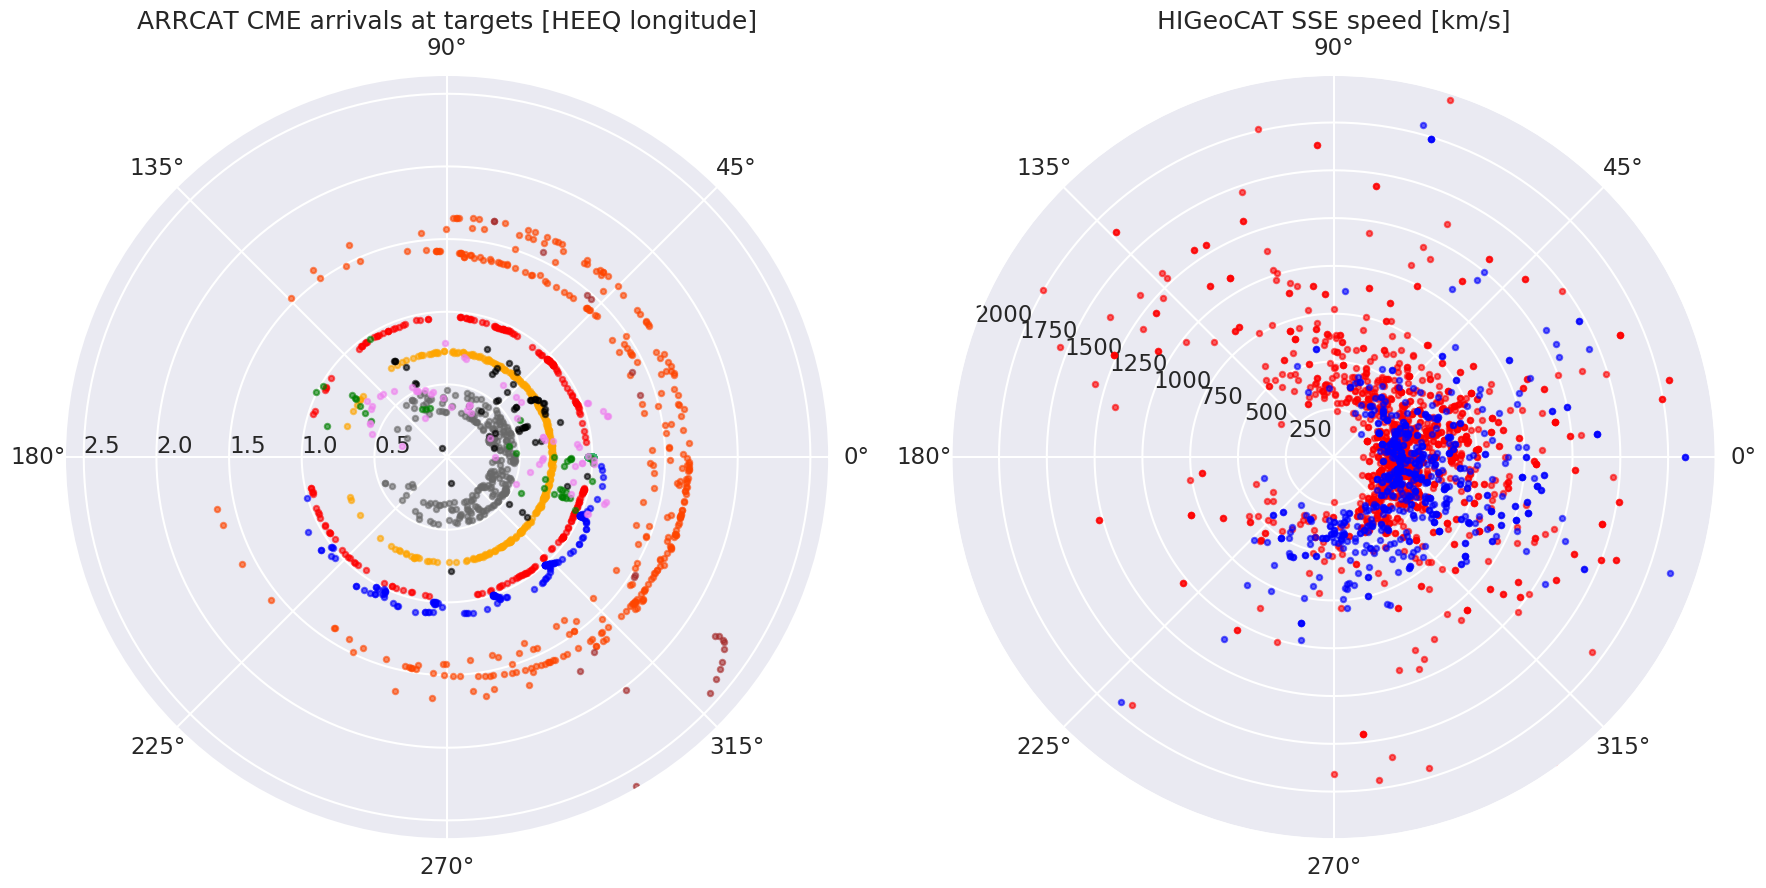

In [12]:

plt.rcParams["figure.figsize"] = (19,11)

sns.set_context('talk')
sns.set_style('darkgrid')



fig=plt.figure(1, figsize=(18,10), dpi=100) 
ax = plt.subplot(121,projection='polar') 

plt.title('ARRCAT CME arrivals at targets [HEEQ longitude]')

#get indices for each target
merci=np.where(ac.target_name=='Mercury')[0]
venusi=np.where(ac.target_name=='Venus')[0]
earthi=np.where(ac.target_name=='Earth_L1')[0]
marsi=np.where(ac.target_name=='Mars')[0]

stai=np.where(ac.target_name=='STEREO-A')[0]
stbi=np.where(ac.target_name=='STEREO-B')[0]
pspi=np.where(ac.target_name=='PSP')[0]
soloi=np.where(ac.target_name=='SolarOrbiter')[0]
bepii=np.where(ac.target_name=='BepiColombo')[0]
ulyi=np.where(ac.target_name=='Ulysses')[0]

#markersize
ms=15
#alpha
al=0.6

ax.scatter(np.radians(ac.target_heeq_lon[merci]),ac.target_distance[merci],s=ms,c='dimgrey', alpha=al)
ax.scatter(np.radians(ac.target_heeq_lon[venusi]),ac.target_distance[venusi],s=ms,c='orange', alpha=al)
ax.scatter(np.radians(ac.target_heeq_lon[earthi]),ac.target_distance[earthi],s=ms,c='mediumseagreen', alpha=al)
ax.scatter(np.radians(ac.target_heeq_lon[marsi]),ac.target_distance[marsi],s=ms,c='orangered', alpha=al)

ax.scatter(np.radians(ac.target_heeq_lon[stai]),ac.target_distance[stai],s=ms,c='red', alpha=al)
ax.scatter(np.radians(ac.target_heeq_lon[stbi]),ac.target_distance[stbi],s=ms,c='blue', alpha=al)

ax.scatter(np.radians(ac.target_heeq_lon[pspi]),ac.target_distance[pspi],s=ms,c='black', alpha=al)
ax.scatter(np.radians(ac.target_heeq_lon[soloi]),ac.target_distance[soloi],s=ms,c='green', alpha=al)
ax.scatter(np.radians(ac.target_heeq_lon[bepii]),ac.target_distance[bepii],s=ms,c='violet', alpha=al)
ax.scatter(np.radians(ac.target_heeq_lon[ulyi]),ac.target_distance[ulyi],s=ms,c='brown', alpha=al)

plt.ylim([0,np.max(ac.target_distance)+0.02])

#ax.set_theta_zero_location("W")
ax.set_rlabel_position(180)


ax = plt.subplot(122,projection='polar')
plt.title('HIGeoCAT SSE speed [km/s]')
hiai=np.where(ac.sc=='A')[0]
hibi=np.where(ac.sc=='B')[0]

ax.scatter(np.radians(ac.sse_heeq_lon[hiai].astype(float)),ac.sse_speed[hiai],s=ms,c='red', alpha=al)
ax.scatter(np.radians(ac.sse_heeq_lon[hibi].astype(float)),ac.sse_speed[hibi],s=ms,c='blue', alpha=al)

ax.set_rlabel_position(160)
#plt.ylim([0,np.max(ac.sse_speed)+100])
plt.ylim([0,2000])

plt.tight_layout()

plotfile='arrcat/plots_arrcat/arrcat_targets.png'
plt.savefig(plotfile,dpi=100)
print('saved as ',plotfile)

### plot error distributions

/nas/helio/heliofc/miniconda3/envs/helio2/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/nas/helio/heliofc/miniconda3/envs/helio2/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/nas/helio/heliofc/miniconda3/envs/helio2/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.

mean sse_speed error 45 +/- 85  km/s


/nas/helio/heliofc/miniconda3/envs/helio2/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


mean target arrival time error from sse_speed error 6 +/- 31 hours
saved as  arrcat/plots_arrcat/arrcat_errors_dist.png


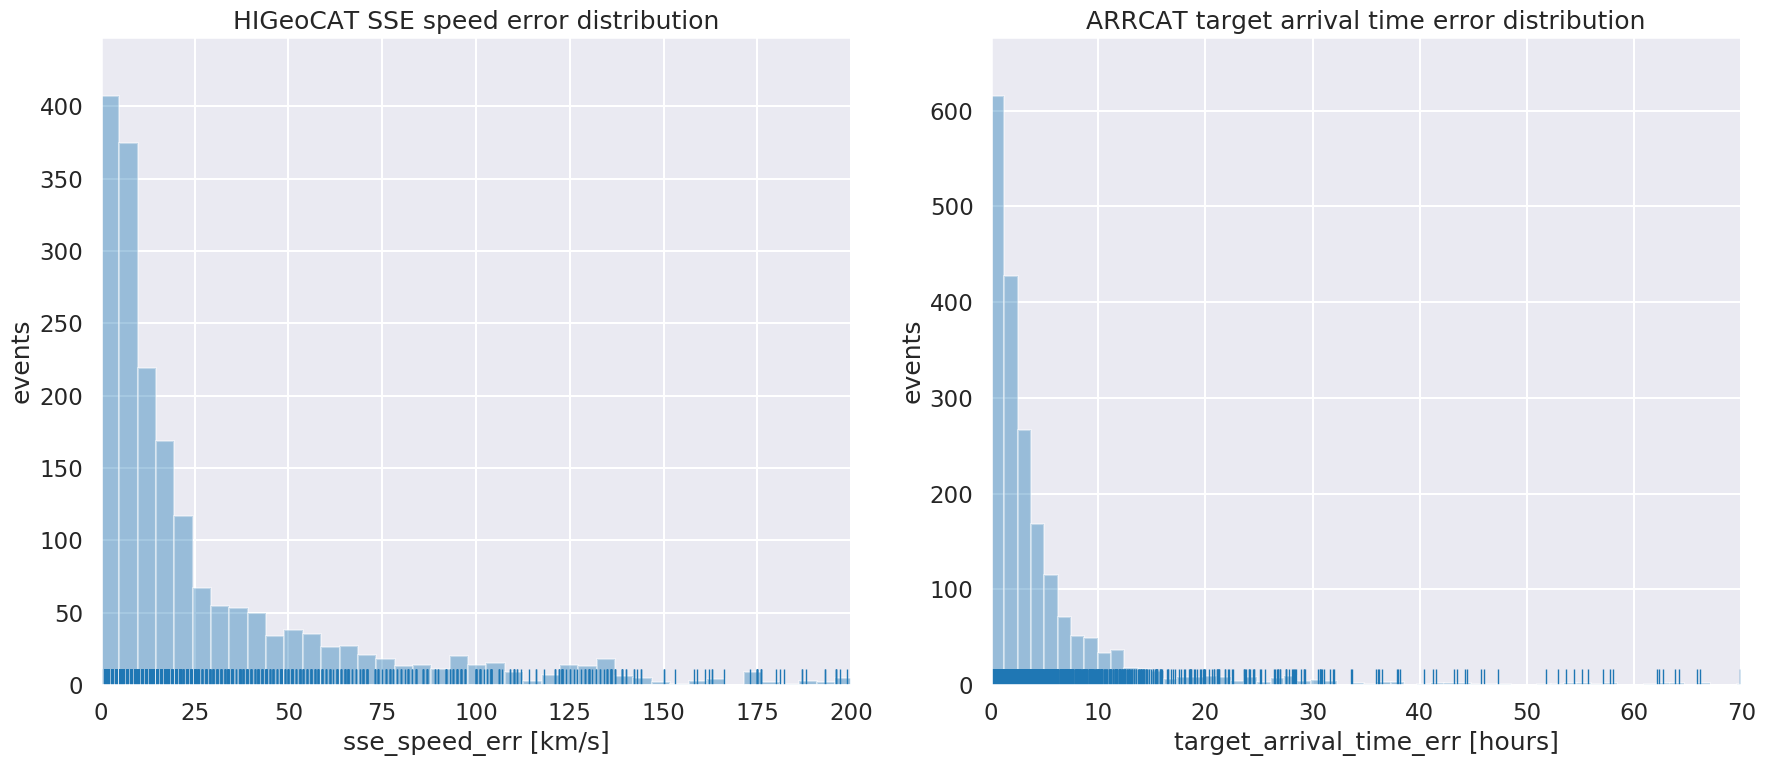

In [13]:
fig=plt.figure(2, figsize=(18,8), dpi=100)

ax = plt.subplot(121) 
sns.distplot(ac.sse_speed_err,bins=200,kde=False,rug=True)
plt.xlim(0,200)
plt.ylabel('events')
plt.xlabel('sse_speed_err [km/s]')
plt.title('HIGeoCAT SSE speed error distribution')
print('mean sse_speed error',np.mean(ac.sse_speed_err).astype(int),'+/-',np.std(ac.sse_speed_err).astype(int),' km/s' )

ax2 = plt.subplot(122) 
sns.distplot(ac.target_arrival_time_err,bins=800,kde=False,rug=True)
plt.xlim(0,70)
plt.title('ARRCAT target arrival time error distribution')
plt.ylabel('events')
plt.xlabel('target_arrival_time_err [hours]')
print('mean target arrival time error from sse_speed error',np.mean(ac.target_arrival_time_err).astype(int),'+/-',np.std(ac.target_arrival_time_err).astype(int),'hours' )

plt.tight_layout()

plotfile='arrcat/plots_arrcat/arrcat_errors_dist.png'
plt.savefig(plotfile,dpi=100)
print('saved as ',plotfile)

## HIGeoCAT CME rates plot






In [14]:
'''
(histmerc1, bin_edgesmerc) = np.histogram(parse_time(ac.sse_launch_time[merci]).jd, yearly_bin_edges)
(histvenus1, bin_edgesvenus) = np.histogram(parse_time(ac.sse_launch_time[venusi]).jd, yearly_bin_edges)
(histearth1, bin_edgesearth) = np.histogram(parse_time(ac.sse_launch_time[earthi]).jd, yearly_bin_edges)
(histmars1, bin_edgesmars) = np.histogram(parse_time(ac.sse_launch_time[marsi]).jd, yearly_bin_edges)
(histstb1, bin_edgesstb) = np.histogram(parse_time(ac.sse_launch_time[stbi]).jd, yearly_bin_edges)
(histsta1, bin_edgessta) = np.histogram(parse_time(ac.sse_launch_time[stai]).jd, yearly_bin_edges)
(histpsp1, bin_edgespsp) = np.histogram(parse_time(ac.sse_launch_time[pspi]).jd, yearly_bin_edges)
(histbepi1, bin_edgesbepi) = np.histogram(parse_time(ac.sse_launch_time[bepi]).jd, yearly_bin_edges)
(histsolo1, bin_edgessolo) = np.histogram(parse_time(ac.sse_launch_time[soloi]).jd, yearly_bin_edges)


# these are for arrcat
hiai=np.where(ac.sc=='A')[0]
hibi=np.where(ac.sc=='B')[0]


(hist_hia, binedges) = np.histogram(parse_time(ac.sse_launch_time[hiai]).plot_date, yearly_bin_edges)
(hist_hib, binedges) = np.histogram(parse_time(ac.sse_launch_time[hibi]).plot_date, yearly_bin_edges)


'''


"\n(histmerc1, bin_edgesmerc) = np.histogram(parse_time(ac.sse_launch_time[merci]).jd, yearly_bin_edges)\n(histvenus1, bin_edgesvenus) = np.histogram(parse_time(ac.sse_launch_time[venusi]).jd, yearly_bin_edges)\n(histearth1, bin_edgesearth) = np.histogram(parse_time(ac.sse_launch_time[earthi]).jd, yearly_bin_edges)\n(histmars1, bin_edgesmars) = np.histogram(parse_time(ac.sse_launch_time[marsi]).jd, yearly_bin_edges)\n(histstb1, bin_edgesstb) = np.histogram(parse_time(ac.sse_launch_time[stbi]).jd, yearly_bin_edges)\n(histsta1, bin_edgessta) = np.histogram(parse_time(ac.sse_launch_time[stai]).jd, yearly_bin_edges)\n(histpsp1, bin_edgespsp) = np.histogram(parse_time(ac.sse_launch_time[pspi]).jd, yearly_bin_edges)\n(histbepi1, bin_edgesbepi) = np.histogram(parse_time(ac.sse_launch_time[bepi]).jd, yearly_bin_edges)\n(histsolo1, bin_edgessolo) = np.histogram(parse_time(ac.sse_launch_time[soloi]).jd, yearly_bin_edges)\n\n\n# these are for arrcat\nhiai=np.where(ac.sc=='A')[0]\nhibi=np.where(ac

saved as  arrcat/plots_arrcat/higeocat_rate.png


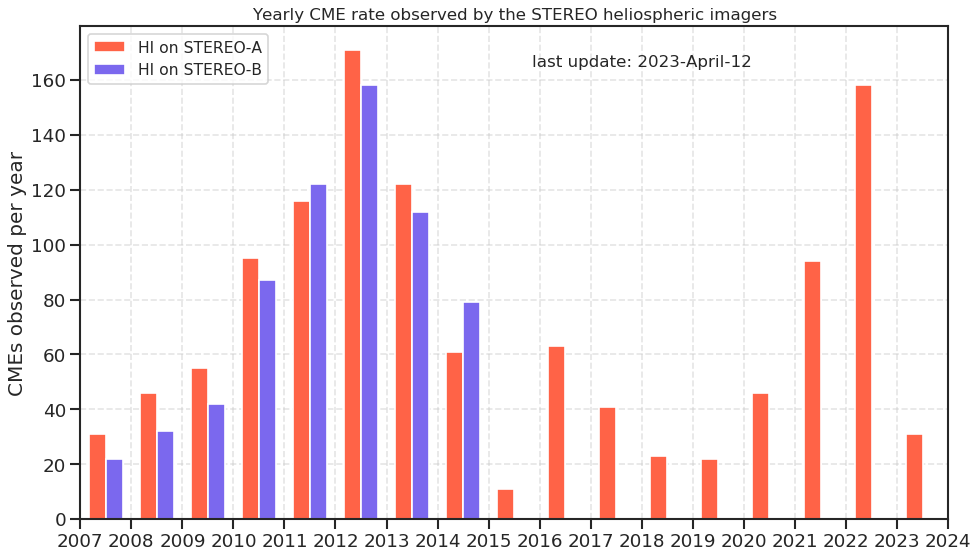

In [15]:
last_year=2024
#define dates of January 1 from 2007 to 2020
years_jan_1_str=[str(i)+'-01-01' for i in np.arange(2007,last_year+1) ] 
yearly_bin_edges=parse_time(years_jan_1_str).plot_date

#
hiai=np.where(higeocat['SC']==b'A')[0]
hibi=np.where(higeocat['SC']==b'B')[0]


hia_t0=higeocat['SSE Launch'][hiai]

hib_t0=higeocat['SSE Launch'][hibi]


(hist_hia, binedges) = np.histogram(parse_time(hia_t0).plot_date, yearly_bin_edges)
(hist_hib, binedges) = np.histogram(parse_time(hib_t0).plot_date, yearly_bin_edges)

#convert back to datetime and make shape consistent
binedges1=binedges[:-1]+mdates.date2num(np.datetime64('0000-12-31'))

#change matplotlib time before plotting
yearly_bin_edges2=yearly_bin_edges + mdates.date2num(np.datetime64('0000-12-31'))


#---------------------------------------------------------------
sns.set_context("talk")     
#sns.set_style('darkgrid')
#sns.set_style('whitegrid',{'grid.linestyle': '--'})

sns.set_style("ticks",{'grid.linestyle': '--'})
fsize=15

fig=plt.figure(1,figsize=(14,8),dpi=80)



ax1 = plt.subplot(111) 
ax1.set_title('Yearly CME rate observed by the STEREO heliospheric imagers',fontsize=15)

ax1.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(myformat)

binweite=365/3
alp=1.0
ax1.bar(binedges1+binweite,hist_hia, width=binweite,color='tomato', alpha=alp,label='HI on STEREO-A')
ax1.bar(binedges1+binweite*2,hist_hib, width=binweite,color='mediumslateblue', alpha=alp,label='HI on STEREO-B')

ax1.set_xlim(yearly_bin_edges2[0],yearly_bin_edges2[-1])
ax1.legend(loc=2,fontsize=14)
ax1.grid(alpha=0.5)
ax1.set_xticks(yearly_bin_edges2) 
ax1.set_ylabel('CMEs observed per year')

ax1.text(yearly_bin_edges2[11],165,'last update: '+last_update,fontsize=15,zorder=2,horizontalalignment='center')


plotfile='arrcat/plots_arrcat/higeocat_rate.png'
plt.savefig(plotfile,dpi=100)
print('saved as ',plotfile)
